### Descripción del dataset VerBio V2

Este dataset contiene información fisiológica de 36 personas las cuales participaron en 10 sesiones de simulación de un discurso en público a través de un dispositivo de realidad virtual.

Se consideran las señales electrodermicas (EDA) obtenidas por la pulsera Empatica E4 de los 36 participantes, en 8 sesiones.

### Obtain / Carga de los datos

Se cargan los datos obtenidos de las sesión 1 a la 8 de los 36 participantes con una frecuencia de muestreo de 4 Hz.
Almacenando la información en el dataframe df_all_tests_EDA_PPT.


In [1]:
import os
import pandas as pd
import numpy as np

In [2]:

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada prueba
df_list_EDA_PPT = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    
    for pid in pid_participants["PID"]:
        # Cargar EDA_PPT.csv
        file_path_ppt = f'{test_folder}/E4/{pid}/EDA_PPT.csv'
        # Verificar si existe el valor de "State Anxiety Enthusiasm Score" para el participante actual
        
        if os.path.exists(file_path_ppt):
            df_pid_ppt = pd.read_csv(file_path_ppt)
            df_pid_ppt['PID'] = pid  # Añadir una columna para identificar el PID
            df_pid_ppt['Test'] = test_folder  # Añadir una columna para identificar la prueba
            df_list_EDA_PPT.append(df_pid_ppt)

# Concatenar todos los DataFrames en uno solo
df_all_tests_EDA_PPT = pd.concat(df_list_EDA_PPT, ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
print("EDA_PPT DataFrame:")
print(df_all_tests_EDA_PPT.tail())

EDA_PPT DataFrame:
        Time (s)      EDA   PID    Test
229778   173.352  0.97374  P073  TEST08
229779   173.602  0.98270  P073  TEST08
229780   173.852  0.99423  P073  TEST08
229781   174.102  0.98526  P073  TEST08
229782   174.352  0.99167  P073  TEST08


### Scrub / Limpieza de los datos

#### Proceso de deconvolución de las señal

Las señales EDA se componen de dos señales que se combinan (convolucionan), estas son:

**Nivel Electrodérmico (ECL o SCL )**: Es la señal de base, que varía lentamente a lo largo del tiempo.
Representa la actividad tónica de las glándulas sudoríparas, esta se puede despreciar ya que informa los cambios en la conductancia electrodérmica en relación con la temperatura y humedad del medio ambiente o el movimiento del cuerpo.

**Respuesta Electrodérmica (EDR o SCR)**: Es una señal que varía rápidamente y está estrechamente relacionada con el sistema nervioso simpático (SNS) encargado de preparar el cuerpo para afrontar situaciones de estres. 

Por lo tanto es necesario descomponer la señal EDA para poder aislar los datos obtenidos de señal SCR la cual varía directamente con el estres.

#### Uso de la función cvxEDA

La función `cvxEDA` es proporcionada por Luca Citi y Alberto Greco. Puedes encontrar más información en [este enlace](https://github.com/lciti/cvxEDA/tree/master). Esta se carga directamente del archivo cvxEDA.py

##### Instalación de la dependencia

Para utilizar `cvxEDA`, es necesario instalar la dependencia `cvxopt`. 
Ejecutando el siguiente comando:

pip install cvxopt

In [3]:

from cvxEDA import cvxEDA

# Crear una lista para almacenar los resultados de cada PID y Test
results_list = []

# Obtener las combinaciones únicas de PID y Test
unique_combinations = df_all_tests_EDA_PPT[['PID', 'Test']].drop_duplicates()

# Realizar la desconvolución para cada combinación de PID y Test y almacenar los resultados
for _, row in unique_combinations.iterrows():
    pid = row['PID']
    test = row['Test']
    df_pid_test = df_all_tests_EDA_PPT[(df_all_tests_EDA_PPT['PID'] == pid) & (df_all_tests_EDA_PPT['Test'] == test)]
    
    # Preparar los datos para cvxEDA
    y = df_pid_test['EDA'].values
    t = df_pid_test['Time (s)'].values
    dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

    # Realizar la desconvolución
    [r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

    # Crear un nuevo DataFrame con los resultados
    results = pd.DataFrame({
        'time': df_pid_test['Time (s)'],
        'original_EDA': y,
        'SCL': t,  # Componente tónica (Skin Conductance Level)
        'SCR': r,  # Componente fásica (Skin Conductance Response)
        'PID': pid,  # Añadir una columna para identificar el PID
        'Test': test,  # Añadir una columna para identificar el Test
    })
    
    # Añadir los resultados a la lista
    results_list.append(results)

# Concatenar todos los resultados en un solo DataFrame
all_results_EDA_PPT = pd.concat(results_list, ignore_index=True)


     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.0233e+01 -2.9092e+01  1e+03  4e+01  4e-01
 1: -2.9127e+01 -8.8761e+01  6e+01  2e+00  2e-02
 2: -2.9121e+01 -3.1459e+01  2e+00  3e-02  3e-04
 3: -2.9902e+01 -3.0237e+01  3e-01  3e-04  3e-06
 4: -3.0204e+01 -3.0232e+01  3e-02  3e-05  3e-07
 5: -3.0227e+01 -3.0232e+01  5e-03  3e-07  3e-09
 6: -3.0231e+01 -3.0232e+01  9e-04  3e-08  3e-10
 7: -3.0231e+01 -3.0231e+01  1e-04  2e-09  1e-1

In [4]:
all_results_EDA_PPT.head()

,time,original_EDA,SCL,SCR,PID,Test
0,0.139,0.17678,0.177249,0.000000,P001,TEST01
1,0.389,0.17934,0.178575,0.000000,P001,TEST01
2,0.639,0.17550,0.178761,-0.003261,P001,TEST01
3,0.889,0.17550,0.177624,-0.001637,P001,TEST01
4,1.139,0.17678,0.176315,0.000788,P001,TEST01


### Explore / Exploración

##### Creacion de ventanas de  30 segundos

Se crean ventanas de 30 segundos sobre la medicion de EDA.

Además se agregan las caracteristicas :
Feature Vector = [meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery ]

Estas características se definen en gracias al estudio: Zhu, L., Spachos, P., Ng, P. C., Yu, Y., Wang, Y., Plataniotis, K., & Hatzinakos, D. (año). Stress Detection Through Wrist-Based Electrodermal Activity Monitoring and Machine Learning. IEEE.

In [5]:
import pandas as pd
import numpy as np

# Definir el tamaño de la ventana en segundos
window_size = 30

# Crear una columna para identificar cada ventana en all_results_EDA_PPT
all_results_EDA_PPT['window'] = (all_results_EDA_PPT['time'] // window_size).astype(int)

# Función para calcular las características
def calculate_features(df):
    meanEDA = df['original_EDA'].mean()
    minEDA = df['original_EDA'].min()
    maxEDA = df['original_EDA'].max()
    stdEDA = df['original_EDA'].std()
    meanSCRonsets = df['SCR'].mean()  # Asumiendo que 'SCR' representa los onsets
    meanSCRamp = df['SCR'].max() - df['SCR'].min()  # Amplitud como diferencia entre max y min
    meanSCRrecovery = df['SCR'].mean()  # Asumiendo que 'SCR' representa la recuperación
    
    return pd.Series([meanEDA, minEDA, maxEDA, stdEDA, meanSCRonsets, meanSCRamp, meanSCRrecovery],
                     index=['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery'])


# Agrupar por ventana y calcular características en all_results_EDA_PPT
segmented_results_EDA_PPT = all_results_EDA_PPT.groupby(['PID', 'Test', 'window']).apply(calculate_features).reset_index()

# Añadir la columna Stress_Level a segmented_results_EDA_PPT
stress_levels = all_results_EDA_PPT[['PID', 'Test']].drop_duplicates()
segmented_results_EDA_PPT = pd.merge(segmented_results_EDA_PPT, stress_levels, on=['PID', 'Test'], how='left')




C:\Users\SCP-866\AppData\Local\Temp\ipykernel_12200\3308423933.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_results_EDA_PPT = all_results_EDA_PPT.groupby(['PID', 'Test', 'window']).apply(calculate_features).reset_index()


Contabilizar la cantidad de ventanas

In [6]:
# Mostrar las primeras filas de los DataFrames para verificar

print("\nSegmented Results EDA PPT:")
print(segmented_results_EDA_PPT.head())
print("Cantidad de ventanas para PPT ", len(segmented_results_EDA_PPT))



Segmented Results EDA PPT:
    PID    Test  window   meanEDA   minEDA   maxEDA    stdEDA  meanSCRonsets  \
0  P001  TEST01       0  0.175873  0.17166  0.18447  0.001760       0.000059   
1  P001  TEST01       1  0.176247  0.17038  0.18319  0.002311       0.000182   
2  P001  TEST01       2  0.173271  0.17038  0.17934  0.001712       0.000119   
3  P001  TEST01       3  0.183380  0.17294  0.20240  0.005537       0.000183   
4  P001  TEST01       4  0.184128  0.17934  0.19343  0.002387       0.000344   

   meanSCRamp  meanSCRrecovery  
0    0.007407         0.000059  
1    0.003469         0.000182  
2    0.002684         0.000119  
3    0.004832         0.000183  
4    0.005316         0.000344  
Cantidad de ventanas para PPT  2032


#### Determinación del nivel de estrés

Cada test tiene una carpeta "Annotation" donde se determina el nivel de estrés de cada participante. Cuatro anotadores clasificaron el nivel de estrés utilizando una escala Likert, con los siguientes valores:

- 0: No estresado
- 0.25: Bajo estrés
- 0.5: Estrés moderado
- 0.75: Estres alto
- 1: Muy estresado

La columna "Fused" indica el promedio de las clasificaciones de los anotadores.

Para clasificar el estado de forma binaria, se considera que si el valor de "Fused" es mayor a 0.3, la persona está estresada.

Para calcular el valor dentro de la ventana se considera la moda dentro de este rango.


In [7]:
import os
import pandas as pd

STRESS_INDICATOR = 0.3
WINDOW_SIZE = 30

# Lista de carpetas de prueba
test_folders = [f'TEST0{i}' for i in range(1, 9)]

# Lista para almacenar los DataFrames de cada archivo de anotación
df_list_annotations = []

for test_folder in test_folders:
    # Cargar los datos de los participantes
    pid_participants = pd.read_csv(f'{test_folder}/participant_id.csv')
    
    for pid in pid_participants["PID"]:
        # Construir la ruta del archivo de anotación
        file_path_annotation = f'{test_folder}/Annotation/{test_folder}_{pid}_annotation.csv'
        
        # Verificar si existe el archivo de anotación para el participante actual
        if os.path.exists(file_path_annotation):
            # Cargar solo las columnas "Time (s)" y "Fused"
            df_annotation = pd.read_csv(file_path_annotation, usecols=['Time (s)', 'Fused'])
            
            # Añadir columnas para identificar el PID y la prueba
            df_annotation['PID'] = pid
            df_annotation['Test'] = test_folder
            
            # Calcular la columna stressed
            df_annotation['stressed'] = df_annotation['Fused'].apply(lambda x: 1 if x >= STRESS_INDICATOR else 0)
            
            # Añadir el DataFrame a la lista
            df_list_annotations.append(df_annotation)

# Concatenar todos los DataFrames de anotaciones en uno solo
df_all_annotations = pd.concat(df_list_annotations, ignore_index=True)

# Crear una columna para identificar cada ventana en las anotaciones
df_all_annotations['window'] = (df_all_annotations['Time (s)'] // WINDOW_SIZE).astype(int)

# Agrupar por PID, Test y window, y calcular el promedio de stressed
grouped_annotations = df_all_annotations.groupby(['PID', 'Test', 'window']).agg({
    'stressed': lambda x: x.mode()[0]
}).reset_index()


# Mostrar las primeras filas del DataFrame agrupado para verificar
print("Grouped Annotations with Stressed:")
print(grouped_annotations.head())


Grouped Annotations with Stressed:
    PID    Test  window  stressed
0  P001  TEST01       0         1
1  P001  TEST01       1         1
2  P001  TEST01       2         1
3  P001  TEST01       3         1
4  P001  TEST01       4         1


In [8]:
segmented_results_EDA_PPT.head()

,PID,Test,window,meanEDA,minEDA,maxEDA,stdEDA,meanSCRonsets,meanSCRamp,meanSCRrecovery
0,P001,TEST01,0,0.175873,0.17166,0.18447,0.001760,0.000059,0.007407,0.000059
1,P001,TEST01,1,0.176247,0.17038,0.18319,0.002311,0.000182,0.003469,0.000182
2,P001,TEST01,2,0.173271,0.17038,0.17934,0.001712,0.000119,0.002684,0.000119
3,P001,TEST01,3,0.183380,0.17294,0.20240,0.005537,0.000183,0.004832,0.000183
4,P001,TEST01,4,0.184128,0.17934,0.19343,0.002387,0.000344,0.005316,0.000344


Una vez obtenido el valor de stressed, se añade a las ventanas correspondientes.

In [9]:
# Añadir la columna stressed a segmented_results_EDA_PPT
segmented_results_EDA_PPT = pd.merge(segmented_results_EDA_PPT, grouped_annotations[['PID', 'Test', 'window', 'stressed']], on=['PID', 'Test', 'window'], how='left')

# Mostrar las primeras filas del DataFrame combinado para verificar la carga
print("Segmented Results EDA PPT with Stressed:")
print(segmented_results_EDA_PPT.head())

Segmented Results EDA PPT with Stressed:
    PID    Test  window   meanEDA   minEDA   maxEDA    stdEDA  meanSCRonsets  \
0  P001  TEST01       0  0.175873  0.17166  0.18447  0.001760       0.000059   
1  P001  TEST01       1  0.176247  0.17038  0.18319  0.002311       0.000182   
2  P001  TEST01       2  0.173271  0.17038  0.17934  0.001712       0.000119   
3  P001  TEST01       3  0.183380  0.17294  0.20240  0.005537       0.000183   
4  P001  TEST01       4  0.184128  0.17934  0.19343  0.002387       0.000344   

   meanSCRamp  meanSCRrecovery  stressed  
0    0.007407         0.000059       1.0  
1    0.003469         0.000182       1.0  
2    0.002684         0.000119       1.0  
3    0.004832         0.000183       1.0  
4    0.005316         0.000344       1.0  


### Model / Creación del modelo


Los modelos utilizados y sus métricas de evaluación son los siguientes:

Modelos:
- K-Nearest Neighbors (KNN)
- Naive Bayes
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)

Métricas:

- Accuracy
- Precision
- Recall
- F1 Score
- Mean Squared Error

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Eliminar filas con valores NaN en el DataFrame segmented_results_EDA_PPT
segmented_results_EDA_PPT = segmented_results_EDA_PPT.dropna()

# Seleccionar el Feature Vector y la variable objetivo
features = ['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery']
target = 'stressed'




#### Division entre entrenamiento y pruebas


In [11]:
from sklearn.model_selection import train_test_split

# Asumiendo que segmented_results_EDA_PPT ya está definido y contiene los datos proporcionados

# Obtener los PIDs únicos
unique_pids = segmented_results_EDA_PPT['PID'].unique()

# Dividir los PIDs en conjuntos de entrenamiento, validación y prueba
train_pids, test_pids = train_test_split(unique_pids, test_size=0.1667, random_state=42)  # 1/6 para test
train_pids, val_pids = train_test_split(train_pids, test_size=0.0667, random_state=42)  # 1/15 para validación

# Crear conjuntos de datos basados en los PIDs
train_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(train_pids)]
val_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(val_pids)]
test_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(test_pids)]

# Mostrar la cantidad de sujetos en cada conjunto
print(f"Total de sujetos: {len(unique_pids)}")
print(f"Sujetos para entrenamiento: {len(train_pids)}, {train_pids}")
print(f"Sujetos para validación: {len(val_pids)}, {val_pids}")
print(f"Sujetos para pruebas: {len(test_pids)}, {test_pids}")

# Mostrar las primeras filas de cada conjunto de datos para verificar
print("Conjunto de datos de entrenamiento:")
print(train_data.head())

print("\nConjunto de datos de validación:")
print(val_data.head())

print("\nConjunto de datos de pruebas:")
print(test_data.head())

Total de sujetos: 36
Sujetos para entrenamiento: 27, ['P004' 'P044' 'P041' 'P045' 'P048' 'P037' 'P021' 'P050' 'P067' 'P035'
 'P066' 'P023' 'P071' 'P001' 'P043' 'P020' 'P027' 'P051' 'P046' 'P049'
 'P060' 'P032' 'P061' 'P016' 'P005' 'P058' 'P013']
Sujetos para validación: 2, ['P039' 'P008']
Sujetos para pruebas: 7, ['P073' 'P038' 'P053' 'P062' 'P042' 'P065' 'P047']
Conjunto de datos de entrenamiento:
    PID    Test  window   meanEDA   minEDA   maxEDA    stdEDA  meanSCRonsets  \
0  P001  TEST01       0  0.175873  0.17166  0.18447  0.001760       0.000059   
1  P001  TEST01       1  0.176247  0.17038  0.18319  0.002311       0.000182   
2  P001  TEST01       2  0.173271  0.17038  0.17934  0.001712       0.000119   
3  P001  TEST01       3  0.183380  0.17294  0.20240  0.005537       0.000183   
4  P001  TEST01       4  0.184128  0.17934  0.19343  0.002387       0.000344   

   meanSCRamp  meanSCRrecovery  stressed  
0    0.007407         0.000059       1.0  
1    0.003469         0.000182 

In [12]:
print(train_data.to_string())



       PID    Test  window    meanEDA     minEDA     maxEDA    stdEDA  meanSCRonsets    meanSCRamp  meanSCRrecovery  stressed
0     P001  TEST01       0   0.175873   0.171660   0.184470  0.001760   5.859492e-05  7.406548e-03     5.859492e-05       1.0
1     P001  TEST01       1   0.176247   0.170380   0.183190  0.002311   1.816379e-04  3.468932e-03     1.816379e-04       1.0
2     P001  TEST01       2   0.173271   0.170380   0.179340  0.001712   1.192020e-04  2.684435e-03     1.192020e-04       1.0
3     P001  TEST01       3   0.183380   0.172940   0.202400  0.005537   1.833625e-04  4.832201e-03     1.833625e-04       1.0
4     P001  TEST01       4   0.184128   0.179340   0.193430  0.002387   3.439879e-04  5.315540e-03     3.439879e-04       1.0
5     P001  TEST01       5   0.184822   0.180620   0.190870  0.002119   1.098811e-04  3.648908e-03     1.098811e-04       1.0
6     P001  TEST01       6   0.185110   0.183190   0.189590  0.002467   4.115353e-04  1.985698e-03     4.115353e-04   

#### Entrenamiento

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Asumiendo que segmented_results_EDA_PPT ya está definido y contiene los datos proporcionados

# Obtener los PIDs únicos
unique_pids = segmented_results_EDA_PPT['PID'].unique()

# Dividir los PIDs en conjuntos de entrenamiento, validación y prueba
train_pids, test_pids = train_test_split(unique_pids, test_size=0.1667, random_state=42)  # 1/6 para test
train_pids, val_pids = train_test_split(train_pids, test_size=0.0667, random_state=42)  # 1/15 para validación

# Crear conjuntos de datos basados en los PIDs
train_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(train_pids)]
val_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(val_pids)]
test_data = segmented_results_EDA_PPT[segmented_results_EDA_PPT['PID'].isin(test_pids)]

# Seleccionar el Feature Vector y la variable objetivo
features = ['meanEDA', 'minEDA', 'maxEDA', 'stdEDA', 'meanSCRonsets', 'meanSCRamp', 'meanSCRrecovery']
target = 'stressed'

# Preparar los datos de entrenamiento y prueba
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Manejar los valores faltantes utilizando un SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Función para evaluar el modelo
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    return accuracy, precision, recall, f1, mse

# Crear y entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_imputed, y_train)
y_pred_knn = knn_model.predict(X_test_imputed)
accuracy_knn, precision_knn, recall_knn, f1_knn, mse_knn = evaluate_model(y_test, y_pred_knn)

# Crear y entrenar el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_imputed, y_train)
y_pred_nb = nb_model.predict(X_test_imputed)
accuracy_nb, precision_nb, recall_nb, f1_nb, mse_nb = evaluate_model(y_test, y_pred_nb)

# Crear y entrenar el modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_imputed, y_train)
y_pred_lr = lr_model.predict(X_test_imputed)
accuracy_lr, precision_lr, recall_lr, f1_lr, mse_lr = evaluate_model(y_test, y_pred_lr)

# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_imputed, y_train)
y_pred_rf = rf_model.predict(X_test_imputed)
accuracy_rf, precision_rf, recall_rf, f1_rf, mse_rf = evaluate_model(y_test, y_pred_rf)

# Crear y entrenar el modelo SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_imputed, y_train)
y_pred_svm = svm_model.predict(X_test_imputed)
accuracy_svm, precision_svm, recall_svm, f1_svm, mse_svm = evaluate_model(y_test, y_pred_svm)

# Imprimir las métricas de evaluación para cada modelo
print("KNN Model")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
print(f"Mean Squared Error: {mse_knn}")

print("Naive Bayes Model")
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")
print(f"Mean Squared Error: {mse_nb}")

print("Logistic Regression Model")
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1 Score: {f1_lr}")
print(f"Mean Squared Error: {mse_lr}")

print("Random Forest Model")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print(f"Mean Squared Error: {mse_rf}")

print("SVM Model")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")
print(f"Mean Squared Error: {mse_svm}")

KNN Model
Accuracy: 0.5928571428571429
Precision: 0.6059061724792062
Recall: 0.5928571428571429
F1 Score: 0.5911585477102718
Mean Squared Error: 0.40714285714285714
Naive Bayes Model
Accuracy: 0.611904761904762
Precision: 0.6562830223381487
Recall: 0.611904761904762
F1 Score: 0.5574402080312072
Mean Squared Error: 0.3880952380952381
Logistic Regression Model
Accuracy: 0.6404761904761904
Precision: 0.6591930482884978
Recall: 0.6404761904761904
F1 Score: 0.6150395035949382
Mean Squared Error: 0.3595238095238095
Random Forest Model
Accuracy: 0.6785714285714286
Precision: 0.6800166746687775
Recall: 0.6785714285714286
F1 Score: 0.6789828717719488
Mean Squared Error: 0.32142857142857145
SVM Model
Accuracy: 0.6333333333333333
Precision: 0.666498635491521
Recall: 0.6333333333333333
F1 Score: 0.5960222016651249
Mean Squared Error: 0.36666666666666664


### Aplicación de busqueda en grilla en SVM

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir el modelo base
svm_model = SVC()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],        # Valores comunes para ajustar
    'kernel': ['linear', 'rbf'],   # Comparar núcleos lineales y no lineales
    'gamma': ['scale', 'auto']     # Ajuste automático o basado en tamaño de datos
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica objetivo (puede ser F1, precision, etc.)
    cv=5,                # Validación cruzada de 5 particiones
    verbose=2            # Nivel de detalle al imprimir resultados
)

# Ajustar la búsqueda en grilla
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y desempeño
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor puntaje de validación cruzada:", best_score)

# Entrenar el modelo final con los mejores hiperparámetros
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)

# Evaluar el modelo final
accuracy_svm, precision_svm, recall_svm, f1_svm, mse_svm = evaluate_model(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1: {f1_svm}, MSE: {mse_svm}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, k

### Aplicación de búsqueda vayesiana con SVM

In [22]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Definir la función objetivo para la optimización
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Búsqueda en escala logarítmica
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Crear el modelo SVM con los hiperparámetros seleccionados
    svm_model = SVC(C=C, kernel=kernel, gamma=gamma)

    # Validación cruzada para evaluar el desempeño
    score = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy').mean()

    # Optuna intenta maximizar esta métrica
    return score

# Crear el estudio de Optuna
study = optuna.create_study(direction='maximize')  # Maximizar la métrica
study.optimize(objective, n_trials=50)  # Realizar 50 pruebas

# Mostrar los mejores hiperparámetros y el mejor puntaje
print("Mejores hiperparámetros:", study.best_params)
print("Mejor puntaje de validación cruzada:", study.best_value)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_svm_model = SVC(**best_params)
best_svm_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred_svm = best_svm_model.predict(X_test)
accuracy_svm, precision_svm, recall_svm, f1_svm, mse_svm = evaluate_model(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1: {f1_svm}, MSE: {mse_svm}")


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[I 2024-12-04 18:11:46,812] A new study created in memory with name: no-name-a7eba2d0-7f57-4693-975e-979ddc9c3447
C:\Users\SCP-866\AppData\Local\Temp\ipykernel_12200\2547336465.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-12-04 18:12:14,209] Trial 0 finished with value: 0.5541106545007082 and parameters: {'C': 21.499136364928336, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.5541106545007082.
C:\Users\SCP-866\AppData\Local\Temp\ipykernel_12200\2547336465.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

Mejores hiperparámetros: {'C': 73.6535566565786, 'kernel': 'linear', 'gamma': 'scale'}
Mejor puntaje de validación cruzada: 0.5704418286085764
Accuracy: 0.6142857142857143, Precision: 0.6481910927886214, Recall: 0.6142857142857143, F1: 0.5676010583951168, MSE: 0.38571428571428573


### Implementación de XGB y MLP

#### XGB


In [23]:
from xgboost import XGBClassifier

# Crear y entrenar el modelo XGB
xgb_model = XGBClassifier(
    objective='binary:logistic',  # Cambia esto según tu problema (binario o multiclase)
    eval_metric='logloss',       # Métrica común para clasificación binaria
    use_label_encoder=False      # Necesario para versiones recientes de XGBoost
)
xgb_model.fit(X_train_imputed, y_train)

# Realizar predicciones
y_pred_xgb = xgb_model.predict(X_test_imputed)

# Evaluar el modelo
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, mse_xgb = evaluate_model(y_test, y_pred_xgb)

# Imprimir resultados
print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1: {f1_xgb}, MSE: {mse_xgb}")


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBoost - Accuracy: 0.6285714285714286, Precision: 0.6295381237148899, Recall: 0.6285714285714286, F1: 0.628926749271137, MSE: 0.37142857142857144


#### MLP

In [25]:
from sklearn.neural_network import MLPClassifier

# Crear y entrenar el modelo MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  # Una capa oculta con 100 neuronas (puedes ajustar)
    activation='relu',          # Función de activación (relu es la más común)
    solver='adam',              # Optimizador para el descenso de gradiente
    max_iter=300,               # Número máximo de iteraciones
    random_state=42             # Fijar semilla para reproducibilidad
)
mlp_model.fit(X_train_imputed, y_train)

# Realizar predicciones
y_pred_mlp = mlp_model.predict(X_test_imputed)

# Evaluar el modelo
accuracy_mlp, precision_mlp, recall_mlp, f1_mlp, mse_mlp = evaluate_model(y_test, y_pred_mlp)

# Imprimir resultados
print(f"MLP - Accuracy: {accuracy_mlp}, Precision: {precision_mlp}, Recall: {recall_mlp}, F1: {f1_mlp}, MSE: {mse_mlp}")


MLP - Accuracy: 0.7952380952380952, Precision: 0.8014698233559486, Recall: 0.7952380952380952, F1: 0.7922293488824101, MSE: 0.20476190476190476


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.


### Interpret / Interpretación

Accuracy: La precisión más alta se obtuvo con el modelo KNN (0.669975), seguido de cerca por Random Forest (0.665012).

Precision: El modelo Naive Bayes mostró la mayor precisión (0.688102), lo que indica que es el mejor en términos de la proporción de verdaderos positivos entre las predicciones positivas.

Recall: KNN y Random Forest obtuvieron los valores más altos de recall (0.669975 y 0.665012, respectivamente), lo que significa que estos modelos son los mejores en identificar correctamente los casos positivos.

F1 Score: KNN también obtuvo el F1 Score más alto (0.668933), seguido de Random Forest (0.664596), lo que indica un buen equilibrio entre precisión y recall.

Mean Squared Error: KNN tuvo el menor error cuadrático medio (0.330025), lo que sugiere que sus predicciones están más cerca de los valores reales en promedio.


C:\Users\SCP-866\AppData\Local\Temp\ipykernel_12200\386927817.py:15: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.


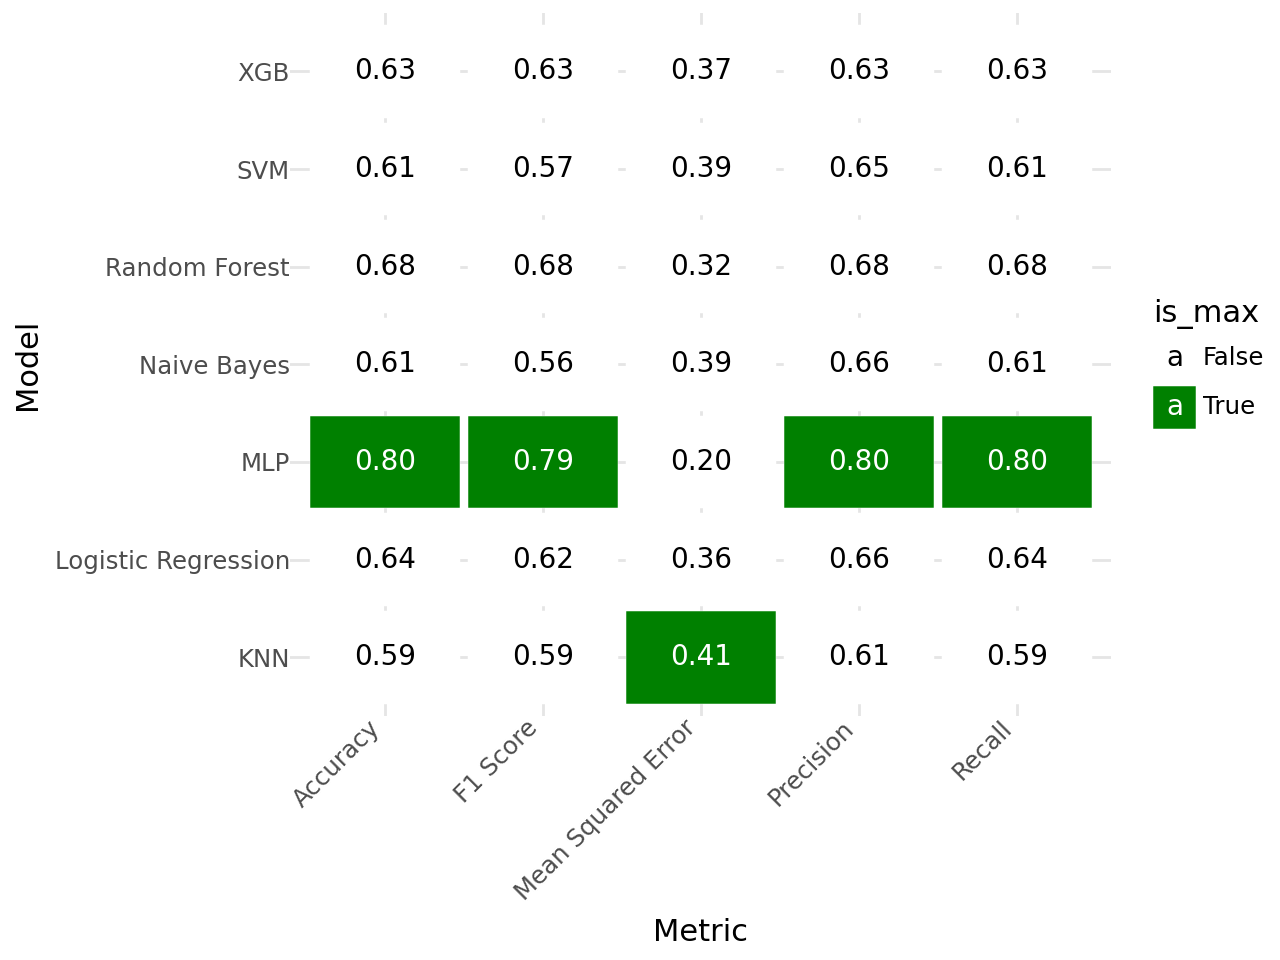

In [29]:
from plotnine import ggplot, aes, geom_tile, geom_text, scale_color_manual, scale_fill_manual, theme_minimal, theme, element_text
# Crear un DataFrame con las métricas de evaluación para cada modelo
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'SVM', 'XGB', 'MLP'],
    'Accuracy': [accuracy_knn, accuracy_nb, accuracy_lr, accuracy_rf, accuracy_svm, accuracy_xgb, accuracy_mlp],
    'Precision': [precision_knn, precision_nb, precision_lr, precision_rf, precision_svm, precision_xgb, precision_mlp],
    'Recall': [recall_knn, recall_nb, recall_lr, recall_rf, recall_svm, recall_xgb, recall_mlp],
    'F1 Score': [f1_knn, f1_nb, f1_lr, f1_rf, f1_svm, f1_xgb, f1_mlp],
    'Mean Squared Error': [mse_knn, mse_nb, mse_lr, mse_rf, mse_svm, mse_xgb, mse_mlp]
})
# Convertir el DataFrame a formato largo
results_long = results.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Identificar los valores máximos para cada métrica
max_values = results_long.groupby('Metric')['Value'].transform(max)
results_long['is_max'] = results_long['Value'] == max_values
from plotnine import ggplot, aes, geom_tile, geom_text, scale_color_manual, scale_fill_manual, theme_minimal, theme, element_text

# Crear el gráfico
p = (ggplot(results_long, aes(x='Metric', y='Model'))
     + geom_tile(aes(width=0.95, height=0.95, fill='is_max'), color='white')
     + geom_text(aes(label='Value', color='is_max'), format_string='{:.2f}', size=10)
     + scale_fill_manual(values=['white', 'green'])  # Blanco para no máximos, verde para máximos
     + scale_color_manual(values=['black', 'white'])  # Texto negro para no máximos, blanco para máximos
     + theme_minimal()
     + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

# Mostrar el gráfico
p

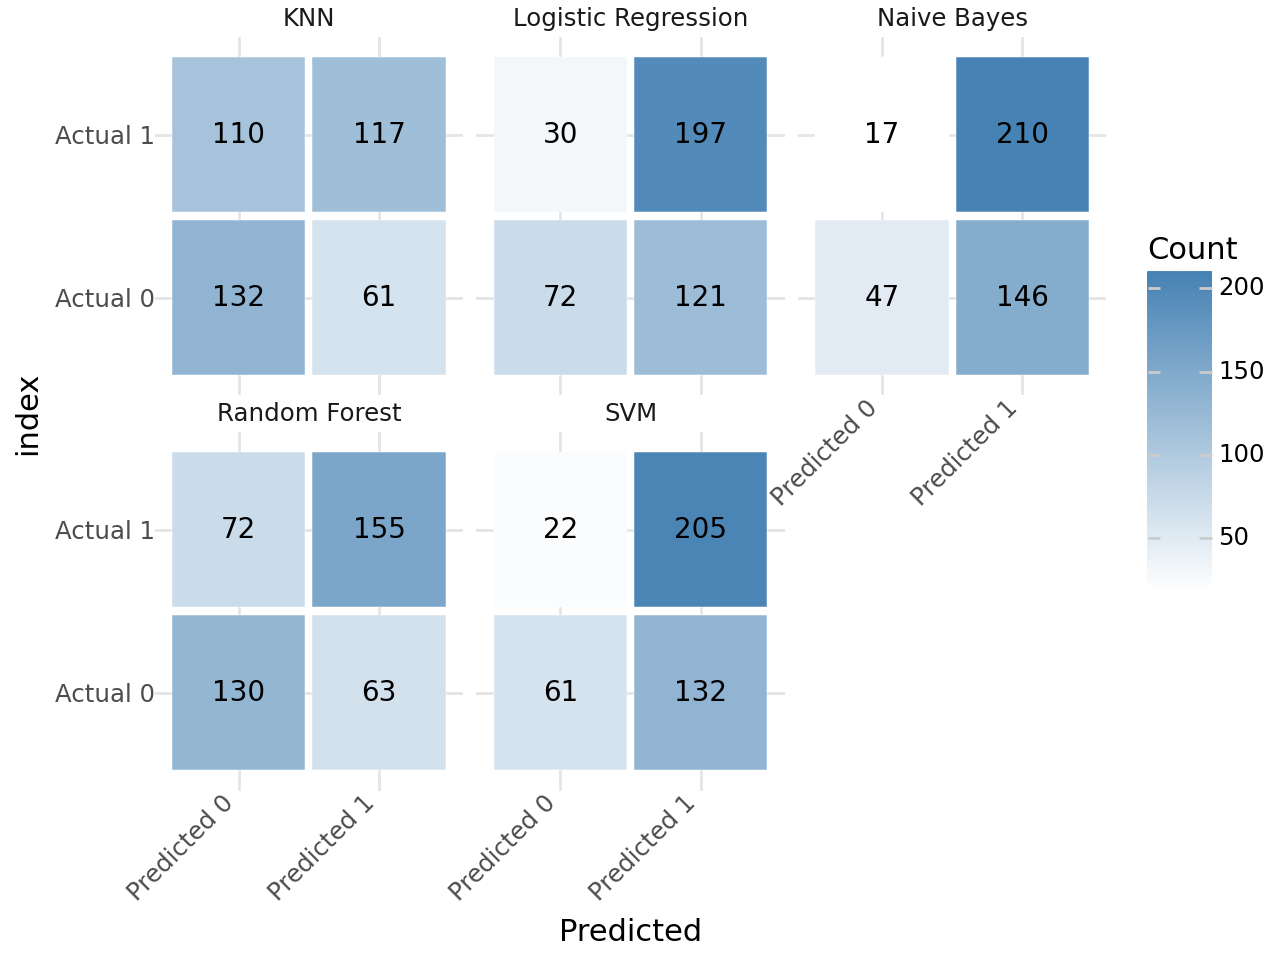

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from plotnine import facet_wrap, ggplot, aes, geom_tile, geom_text, scale_fill_gradient, theme_minimal, theme, element_text

# Función para crear una matriz de confusión y convertirla en un DataFrame largo
def create_confusion_matrix_df(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
    cm_df = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
    cm_df['Model'] = model_name
    return cm_df

# Crear matrices de confusión para cada modelo
cm_knn = create_confusion_matrix_df(y_test, y_pred_knn, 'KNN')
cm_nb = create_confusion_matrix_df(y_test, y_pred_nb, 'Naive Bayes')
cm_lr = create_confusion_matrix_df(y_test, y_pred_lr, 'Logistic Regression')
cm_rf = create_confusion_matrix_df(y_test, y_pred_rf, 'Random Forest')
cm_svm = create_confusion_matrix_df(y_test, y_pred_svm, 'SVM')

# Concatenar todas las matrices de confusión en un solo DataFrame
cm_all = pd.concat([cm_knn, cm_nb, cm_lr, cm_rf, cm_svm], ignore_index=True)

# Crear el gráfico de matrices de confusión usando plotnine
p = (ggplot(cm_all, aes(x='Predicted', y='index', fill='Count'))
     + geom_tile(aes(width=0.95, height=0.95), color='white')
     + geom_text(aes(label='Count'), size=10)
     + scale_fill_gradient(low='white', high='steelblue')
     + theme_minimal()
     + theme(axis_text_x=element_text(rotation=45, hjust=1))
     + facet_wrap('~Model')
    )

# Mpostrar el gráfico
p